# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs`associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

## 1 Data Preparation
### Load utiles


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from math import sqrt

### Load DataFrames

In [2]:
from olist.seller import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers

# from olist.order import Order
# order = Order()
# orders = order.get_training_data()
# orders

# from olist.order_items import Order_items
# order_item = Order_items()
# order_items = order_item.get_order_items()
# order_items.head(50)

# specific_seller_id = '001ab0a7578dd66cd4b0a71f5b6e1e41'
# filtered_df = order_items[order_items.order_id == specific_seller_id]
# filtered_df

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025000,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000000,167.99,16.799,-83.201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0,2,2,1.000000,158.00,15.800,15.800
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140,10,10,1.000000,889.00,1208.900,1068.900
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0,6,7,1.166667,550.04,455.004,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,50,8,11,1.375000,297.00,349.700,299.700


In [22]:
seller_df = sellers[['seller_id', 'revenues', 'cost_of_reviews', 'profits', 'quantity']]
sellers_df = seller_df.sort_values(by='profits', ascending=True)
sellers_df

,seller_id,revenues,cost_of_reviews,profits,quantity
769,6560211a19b47992c3666cc44a7e94c0,13770.483,35290,-21519.517,2033
2358,4a3ca9315b744ce9f8e9374361493884,21647.292,39400,-17752.708,1987
1357,cc419e0650a3c5ba77189a1882b7556a,11948.842,29530,-17581.158,1775
945,ea8482cd71df3c1969d7b9473ff13abc,4677.752,20220,-15542.248,1203
315,8b321bb669392f5163d04c59e235e066,2553.569,15440,-12886.431,1018
...,...,...,...,...,...
2830,46dc3b2cc0980fb8ec44634e21d2718e,14571.119,7500,7071.119,542
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,8808.455,1520,7288.455,175
534,fa1c13f2614d7b5c4749cbc52fecda94,21004.203,6510,14494.203,586
67,7e93a43ef30c4f03f38b393420bc753a,19323.187,4700,14623.187,340


In [8]:
def updated(sellers_df, seller_id):
    # drop the seller
    sellers_df = sellers_df.iloc[seller_id:]

    # Calculate IT costs
    alpha = 3157.27
    beta = 978.23
    it_costs = alpha * np.sqrt(len(sellers_df)) + beta * np.sqrt(sellers_df['quantity'].sum())

    total_profits = sellers_df['profits'].sum() - it_costs
    total_revenues = sellers_df['revenues'].sum()
    profit_margin = (total_profits / total_revenues) * 100

    profits = sellers_df['profits'].sum() - it_costs

    return it_costs, profit_margin, profits

def optimal_n(sellers_df):
    # Initial profit margin and profits before removing any sellers
    total_profits = sellers_df['profits'].sum() - 500000
    total_revenues = sellers_df['revenues'].sum()
    initial_profit_margin = (total_profits / total_revenues) * 100

    initial_profits = sellers_df['profits'].sum() - 500000

    #profit_margin and profits after removing i sellers
    optimal_profit_margin = initial_profit_margin
    optimal_profits = initial_profits
    optimal_n_sellers = 0

    for i in range(len(sellers_df)):
        # Update IT costs, profit_margin, profits by removing i seller
        it_costs, profit_margin, profits = updated(sellers_df, i)

        # Check if current scenario improves profit margin and profits
        if profit_margin > optimal_profit_margin and profits > optimal_profits:
            optimal_profit_margin = profit_margin
            optimal_profits = profits
            optimal_n_sellers = i + 1  # Number of removed sellers


    return initial_profit_margin, initial_profits, optimal_n_sellers, optimal_profit_margin, optimal_profits

# Execute the code
initial_profit_margin, initial_profits, optimal_n_sellers, profit_margin, profits = optimal_n(sellers_df)

# Print the results
print("Initial profit margin:", initial_profit_margin)
print("Initial profit:", initial_profits)
print("Optimal number of sellers to remove:", optimal_n_sellers)
print("Optimal profit margin:", profit_margin)
print("Optimal profits:", profits)


Initial profit margin: 23.964535285415753
Initial profit: 667608.4440000001
Optimal number of sellers to remove: 856
Optimal profit margin: 46.91166362351736
Optimal profits: 1070976.1160162983


In [9]:
def updated(sellers_df, seller_id):
    # drop the seller
    sellers_df = sellers_df.iloc[seller_id:]

    # Calculate IT costs
    alpha = 3157.27
    beta = 978.23
    it_costs = alpha * np.sqrt(len(sellers_df)) + beta * np.sqrt(sellers_df['quantity'].sum())

    total_profits = sellers_df['profits'].sum() - it_costs
    total_revenues = sellers_df['revenues'].sum()
    profit_margin = (total_profits / total_revenues) * 100

    profits = sellers_df['profits'].sum() - it_costs

    return it_costs, profit_margin, profits

print(updated(sellers_df, 856))

(395917.2183009593, 46.913109544442136, 1070967.5326990406)


In [ ]:
proble first
how
why


In [16]:
dfs = []

for i in range(len(sellers_df)):
    # Update IT costs, profit_margin, profits by removing i seller
    it_costs, profit_margin, profits = updated(sellers_df, i)

    # Create a DataFrame for current iteration
    df = pd.DataFrame({'number_seller_removed': [i], 'profit_margin': [profit_margin], 'profits': [profits]})

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list
results_df = pd.concat(dfs, ignore_index=True)
results_df.set_index('number_seller_removed', inplace=True)
results_df

,profit_margin,profits
number_seller_removed,,
0,23.964560,667609.125481
1,24.968420,692136.571883
2,25.918276,712856.431848
3,26.771116,733114.115269
4,27.452607,750492.262699
...,...,...
2962,11.686820,10161.055257
2963,14.001766,10133.560921
2964,9.377538,5960.831718


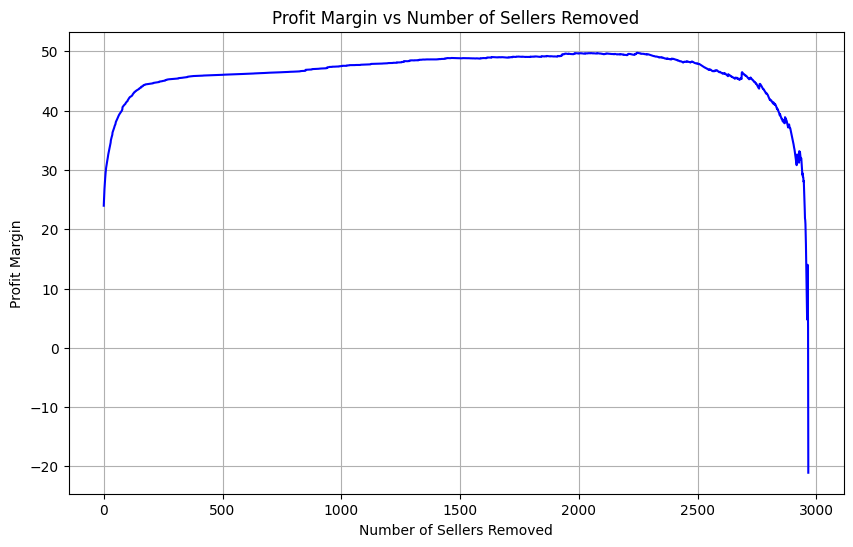

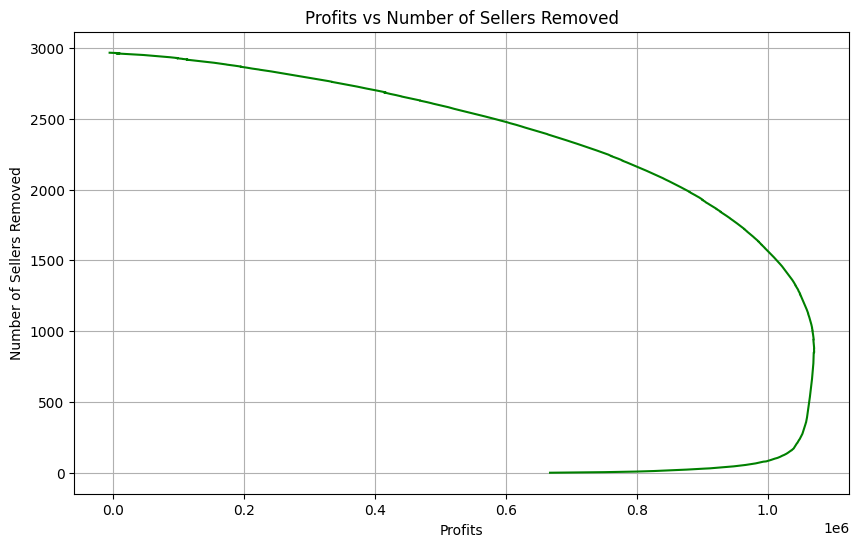

In [20]:
import matplotlib.pyplot as plt

# Plotting profit margins
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['profit_margin'], color='blue')
plt.title('Profit Margin vs Number of Sellers Removed')
plt.xlabel('Number of Sellers Removed')
plt.ylabel('Profit Margin')
plt.grid(True)
plt.show()

# Plotting profits
plt.figure(figsize=(10, 6))
plt.plot(results_df['profits'], results_df.index, color='green')
plt.title('Profits vs Number of Sellers Removed')
plt.xlabel('Profits')
plt.ylabel('Number of Sellers Removed')
plt.grid(True)
plt.show()

In [15]:
import plotly.express as px

results_df = pd.DataFrame(results_df)
fig = px.scatter(df, x="profits", y="number_seller_removed", color="profits")


fig.show()

In [23]:
results_df.describe()

,profit_margin,profits
count,2967.000000,2.967000e+03
mean,46.411422,8.696661e+05
std,4.517364,2.634361e+05
min,-21.074947,-4.897313e+03
25%,45.926547,7.647162e+05
50%,47.643553,9.999769e+05
75%,48.929596,1.060381e+06
max,49.772058,1.070976e+06
